 ## 2.4 向量相似度搜索 (Search) 与混合查询 (Query/Hybrid Search) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/richzw/milvus-workshop/blob/main/ch2/ch2_4.ipynb) 

 在前面的部分，我们已经学会了如何创建 Collection、插入数据、并为向量字段构建索引。现在，我们将利用这些基础，探索 Milvus 的核心功能：向量相似度搜索、基于标量字段的查询以及强大的混合查询。

 ### 概念：向量搜索 (Search) - 根据输入的向量查找最相似的 Top K 个向量

 **向量搜索 (Vector Search)** 是 Milvus 最核心的功能。它的目标是：给定一个或多个查询向量 (query vectors)，在 Collection 中快速找到与这些查询向量最相似的 K 个向量（即 Top K results）。

 - **输入**:
     - 查询向量 (Query Vectors): 一个或多个与 Collection 中存储的向量具有相同维度的向量。
     - Top K: 希望返回的最相似结果的数量。
     - 搜索参数: 控制搜索行为的参数，如使用的索引参数、过滤条件等。
 - **过程**: Milvus 利用之前为向量字段构建的索引（如 HNSW, IVF\_FLAT），高效地在大量向量中定位候选集，并计算查询向量与这些候选向量之间的距离/相似度，最终返回最相似的 Top K 个结果。
 - **输出**: 通常包含每个匹配实体的 ID、与查询向量的距离/相似度得分，以及指定的其他标量字段。

 ### 实操：执行向量搜索

 我们将使用之前练习中创建并已建立索引的 `book_search` Collection 进行向量搜索。

 **前提**:
 1.  Milvus 服务已连接 (`client` 对象可用)。
 2.  `book_search` Collection 已存在，包含数据，并且其向量字段 `book_embedding` **已成功创建索引并加载到内存中**。


In [19]:
# 确保 MilvusClient 'client' 已经从前面部分初始化并连接
from pymilvus import MilvusClient
import numpy as np
MILVUS_URI = "http://localhost:19530"
client = MilvusClient(uri=MILVUS_URI)

# 定义 Collection 和相关字段名称
SEARCH_COLLECTION_NAME = "book_search" # 与之前练习一致
SEARCH_VECTOR_FIELD_NAME = "book_embedding" # 向量字段名
DIMENSION_SEARCH = 768 # 向量维度，必须与 Collection Schema 一致

# 1. 确保 Collection 已加载 
try:
    print(f"确保 Collection '{SEARCH_COLLECTION_NAME}' 已加载以进行搜索...")
    # client.load_collection 是阻塞的，会等待加载完成 (或超时)
    client.load_collection(collection_name=SEARCH_COLLECTION_NAME)
    print(f"Collection '{SEARCH_COLLECTION_NAME}' 已成功加载或已处于加载状态。")
    
    # (可选) 检查加载状态
    load_state = client.get_load_state(collection_name=SEARCH_COLLECTION_NAME)
    print(f"Collection 加载状态: {load_state}")
    if load_state.get('state') != 1 and load_state.get('state') != "LoadStateLoaded": # 'state': <LoadState.Loaded: 1>
        # 对于 MilvusClient 2.4.x, load_state['state'] 是 <LoadState.Loaded: 1>
        # 对于旧版本可能是字符串，或者直接是数字
        # 此处做简单检查，实际 LoadState 的枚举值可能更复杂
        is_loaded = False
        if isinstance(load_state.get('state'), int): # pymilvus 2.3.x style
            is_loaded = (load_state.get('state') == 1) # 1 通常表示 Loaded
        elif hasattr(load_state.get('state'), 'name'): # pymilvus 2.4.x style, state is an Enum member
            is_loaded = (load_state.get('state').name == 'Loaded')
        
        if not is_loaded:
            print(f"警告: Collection '{SEARCH_COLLECTION_NAME}' 加载状态并非完全加载，搜索可能失败或不准确。")
            # 考虑如果没加载就重新尝试加载或抛出错误
            # client.load_collection(collection_name=SEARCH_COLLECTION_NAME)
            # print("再次尝试加载...")


except Exception as e:
    print(f"加载 Collection '{SEARCH_COLLECTION_NAME}' 失败: {e}")
    # 如果加载失败，搜索将无法进行
    raise ValueError(f"无法加载 Collection '{SEARCH_COLLECTION_NAME}'，搜索操作无法继续。")

确保 Collection 'book_search' 已加载以进行搜索...
Collection 'book_search' 已成功加载或已处于加载状态。
Collection 加载状态: {'state': <LoadState: Loaded>}
警告: Collection 'book_search' 加载状态并非完全加载，搜索可能失败或不准确。


In [2]:
# 2. 准备搜索向量 (Query Vectors)
# 通常，查询向量来自用户输入、另一个模型等。这里我们随机生成一个或多个。
num_query_vectors = 1
query_vectors = [np.random.rand(DIMENSION_SEARCH).astype(np.float32).tolist() for _ in range(num_query_vectors)]
# 如果只搜索一个向量，也可以直接传递一个列表:
# query_vectors = np.random.rand(DIMENSION_SEARCH).astype(np.float32).tolist() # 错误，search data 必须是 list of list
# query_vectors = [np.random.rand(DIMENSION_SEARCH).astype(np.float32).tolist()] # 正确


print(f"准备了 {len(query_vectors)} 个查询向量。")
# print(f"第一个查询向量 (前5维): {query_vectors[0][:5]}")

准备了 1 个查询向量。


In [3]:
# 3. 设置搜索参数
# 这些参数会影响搜索的行为和性能
top_k = 5 # 返回最相似的 5 个结果

# 索引相关的搜索参数 (search_params)
# - 对于 HNSW 索引，关键参数是 `ef` (搜索时动态列表的大小)
# - 对于 IVF_FLAT, IVF_SQ8 等，关键参数是 `nprobe` (查询时搜索的簇数量)
# 这些参数通常在创建索引时指定了 metric_type, index_type
# search_params 字典中的 "params" 是针对特定索引类型的搜索时参数
# metric_type 应该与索引创建时一致
search_params_hnsw = {
    "metric_type": "L2", # 必须与索引创建时一致
    "params": {"ef": 64}, # ef 越大，召回率越高，但越慢。通常 ef > top_k
}

# search_params_ivf = {
#     "metric_type": "L2",
#     "params": {"nprobe": 10},
# }

# 假设我们为 'book_embedding' 字段创建的是 HNSW 索引，则使用 search_params_hnsw
current_search_params = search_params_hnsw

# 4. 执行向量搜索
print(f"\n开始执行向量搜索 (Top K = {top_k})...")
try:
    search_results = client.search(
        collection_name=SEARCH_COLLECTION_NAME,
        data=query_vectors,                       # 查询向量列表 (list of lists)
        anns_field=SEARCH_VECTOR_FIELD_NAME,      # 要在其上进行搜索的向量字段名
        limit=top_k,                              # 返回结果的数量 (Top K)
        search_params=current_search_params,      # 索引相关的搜索参数
        # expr="publication_year > 2000",         # (可选) 混合搜索的过滤条件，稍后介绍
        output_fields=["book_title", "publication_year"], # (可选) 希望在结果中返回的标量字段
        consistency_level="Strong"                # (可选) 一致性级别，默认 "Bounded"
                                                  # Strong: 保证读取最新数据，但延迟可能较高
                                                  # Bounded: 允许一定程度的数据过时，性能较好
    )
    print("向量搜索完成。")

    # 5. 解释搜索结果
    # search_results 是一个列表，每个元素对应一个查询向量的结果
    # 每个查询向量的结果本身也是一个列表，包含 Top K 个匹配项
    # 每个匹配项是一个字典 (OmitZeroDict)，包含 'id', 'distance', 和指定的 'output_fields'
    
    if not search_results:
        print("搜索没有返回任何结果。")
    else:
        for i, hits in enumerate(search_results): # hits 对应一个查询向量的所有匹配
            print(f"\n查询向量 #{i+1} 的结果:")
            if not hits:
                print("  没有找到匹配项。")
            else:
                for hit in hits: # hit 对应一个匹配实体
                    # hit 是一个 pymilvus.client.types.Hit 对象或类似字典的对象
                    # 可以通过 hit.id, hit.distance, hit.entity.get("field_name") 访问
                    # 或者像字典一样访问 hit['id'], hit['distance'], hit['entity']['field_name']
                    # (取决于PyMilvus版本，MilvusClient通常返回类似字典的结构)
                    
                    entity_id = hit.get('id')
                    distance = hit.get('distance')
                    fields = hit.get('entity', {}) # 'entity' 键包含 output_fields
                    
                    print(f"  - ID: {entity_id}, 距离: {distance:.4f}")
                    if "book_title" in fields:
                        print(f"    书名: {fields['book_title']}")
                    if "publication_year" in fields:
                        print(f"    出版年份: {fields['publication_year']}")
                    # 也可以直接打印 hit 对象来查看其结构
                    # print(f"    原始 Hit 对象: {hit}")


except Exception as e:
    print(f"向量搜索失败: {e}")
    raise


开始执行向量搜索 (Top K = 5)...
向量搜索完成。

查询向量 #1 的结果:
  - ID: None, 距离: 117.9291
    书名: The Amazing Book Title 84
    出版年份: 2023
  - ID: None, 距离: 117.9291
    书名: The Amazing Book Title 84
    出版年份: 2023
  - ID: None, 距离: 117.9291
    书名: The Amazing Book Title 84
    出版年份: 2023
  - ID: None, 距离: 117.9291
    书名: The Amazing Book Title 84
    出版年份: 2023
  - ID: None, 距离: 117.9291
    书名: The Amazing Book Title 84
    出版年份: 2023


 #### 解释搜索参数 (`ef` for HNSW, `nprobe` for IVF)

 这些参数在 `client.search()` 的 `search_params` 字典内的 `"params"` 键中指定，并且它们与创建索引时选择的索引类型紧密相关。

 - **`ef` (for HNSW index)**:
     - **含义**: "Effective Factor"。在 HNSW 图中搜索时，维护的动态候选列表的大小。
     - **影响**:
         - **召回率 (Recall)**: `ef` 值越大，搜索范围越广，找到真实最近邻的可能性就越大，因此召回率通常会提高。
         - **搜索速度 (QPS)**: `ef` 值越大，需要探索和比较的节点就越多，搜索耗时就越长，QPS（每秒查询数）会降低。
     - **建议**: `ef` 的值必须大于等于 `top_k`。通常建议 `ef` 在 `top_k` 的几倍到几十倍之间，具体取决于对召回率和速度的要求。需要实验调优。

 - **`nprobe` (for IVF_FLAT, IVF_SQ8, IVF_PQ indexes)**:
     - **含义**: "Number of Probes"。在基于 IVF（倒排文件）的索引中，当一个查询向量到来时，它首先会与所有簇的中心点（centroids）进行比较，然后选择 `nprobe` 个最相似的簇进行进一步的精确搜索。
     - **影响**:
         - **召回率 (Recall)**: `nprobe` 值越大，搜索的簇越多，包含真实最近邻的簇被选中的概率就越大，召回率通常会提高。
         - **搜索速度 (QPS)**: `nprobe` 值越大，需要在更多簇内部进行搜索，计算量增加，QPS 会降低。
     - **建议**: `nprobe` 的值通常从一个较小的值（如 1, 2）开始，逐步增加，直到在召回率和速度之间达到满意的平衡。它的上限是索引创建时的 `nlist` 参数。

 **调优**: 这些参数是性能调优的关键。通常需要在验证集上进行实验，通过调整这些参数来找到在特定应用场景下召回率和 QPS 的最佳平衡点。


 ### 概念：数据查询 (Query) - 根据 Scalar Field 的过滤条件查找数据

 **数据查询 (Data Query)** 允许您基于标量字段 (Scalar Fields) 的条件来检索实体，这非常类似于传统数据库中的 SQL `WHERE` 子句。它**不涉及向量相似度计算**。

 - **目的**: 筛选出满足特定属性条件的实体。
 - **过滤表达式 (`filter` 或 `expr`)**: 使用一种特定的字符串表达式语法来定义过滤条件。
     - 支持常见的比较运算符: `==`, `!=`, `>`, `<`, `>=`, `<=`
     - 支持逻辑运算符: `and`, `or`, `not`
     - 支持范围查询: `in`, `not in` (例如 `year in [2020, 2021]`)
     - 支持字符串匹配: `like` (例如 `title like "The%"`，`%` 是通配符)
     - 字段名和字符串值需要用适当的引号（通常字段名不需要，字符串值用双引号或单引号）。
 - **输出**: 返回满足过滤条件的所有实体，可以指定 `output_fields` 来获取特定字段，也可以设置 `limit` 和 `offset` 进行分页。

 ### 实操：执行数据查询

 我们将对 `book_search` Collection 执行一些基于标量字段的查询。

In [4]:
print("\n开始执行数据查询...")

# 查询示例 1: 查找特定出版年份的书籍
filter_expr_1 = "publication_year == 2005"
try:
    print(f"\n查询条件: {filter_expr_1}")
    query_results_1 = client.query(
        collection_name=SEARCH_COLLECTION_NAME,
        filter=filter_expr_1, # MilvusClient 2.3+ 使用 filter, 老版本或 Collection 对象用 expr
        output_fields=["book_id", "book_title", "publication_year"],
        limit=10 # 最多返回10条
    )
    print(f"找到 {len(query_results_1)} 条满足条件的实体:")
    for i, entity_dict in enumerate(query_results_1):
        # entity_dict 是一个包含 output_fields 的字典
        print(f"  - 结果 #{i+1}: ID={entity_dict.get('book_id')}, "
              f"标题='{entity_dict.get('book_title')}', "
              f"年份={entity_dict.get('publication_year')}")
except Exception as e:
    print(f"数据查询 (条件1) 失败: {e}")

# 查询示例 2: 查找书名以 "Amazing" 开头且年份大于 2010 的书籍
filter_expr_2 = 'book_title like "The Amazing%" and publication_year > 2010'
# 注意：字符串值 "The Amazing%" 需要用引号包围。字段名通常不需要。
try:
    print(f"\n查询条件: {filter_expr_2}")
    query_results_2 = client.query(
        collection_name=SEARCH_COLLECTION_NAME,
        filter=filter_expr_2,
        output_fields=["book_id", "book_title", "publication_year"],
        limit=5
    )
    print(f"找到 {len(query_results_2)} 条满足条件的实体:")
    for i, entity_dict in enumerate(query_results_2):
        print(f"  - 结果 #{i+1}: ID={entity_dict.get('book_id')}, "
              f"标题='{entity_dict.get('book_title')}', "
              f"年份={entity_dict.get('publication_year')}")
except Exception as e:
    print(f"数据查询 (条件2) 失败: {e}")

# 查询示例 3: 使用 'in' 操作符
filter_expr_3 = "publication_year in [1985, 1995, 2015]"
try:
    print(f"\n查询条件: {filter_expr_3}")
    query_results_3 = client.query(
        collection_name=SEARCH_COLLECTION_NAME,
        filter=filter_expr_3,
        output_fields=["book_id", "book_title", "publication_year"],
        limit=10
    )
    print(f"找到 {len(query_results_3)} 条满足条件的实体:")
    for i, entity_dict in enumerate(query_results_3):
        print(f"  - 结果 #{i+1}: ID={entity_dict.get('book_id')}, "
              f"标题='{entity_dict.get('book_title')}', "
              f"年份={entity_dict.get('publication_year')}")
except Exception as e:
    print(f"数据查询 (条件3) 失败: {e}")


开始执行数据查询...

查询条件: publication_year == 2005
找到 10 条满足条件的实体:
  - 结果 #1: ID=457888763904009144, 标题='The Amazing Book Title 11', 年份=2005
  - 结果 #2: ID=457888763904009216, 标题='The Amazing Book Title 82', 年份=2005
  - 结果 #3: ID=457888763904009226, 标题='The Amazing Book Title 92', 年份=2005
  - 结果 #4: ID=457888763904009229, 标题='The Amazing Book Title 95', 年份=2005
  - 结果 #5: ID=457888763904009246, 标题='The Amazing Book Title 11', 年份=2005
  - 结果 #6: ID=457888763904009318, 标题='The Amazing Book Title 82', 年份=2005
  - 结果 #7: ID=457888763904009328, 标题='The Amazing Book Title 92', 年份=2005
  - 结果 #8: ID=457888763904009331, 标题='The Amazing Book Title 95', 年份=2005
  - 结果 #9: ID=457888763904009348, 标题='The Amazing Book Title 11', 年份=2005
  - 结果 #10: ID=457888763904009420, 标题='The Amazing Book Title 82', 年份=2005

查询条件: book_title like "The Amazing%" and publication_year > 2010
找到 5 条满足条件的实体:
  - 结果 #1: ID=457888763904009138, 标题='The Amazing Book Title 5', 年份=2020
  - 结果 #2: ID=457888763904009139, 标题='The Am

 ### 概念：混合查询 (Hybrid Search) - 结合向量相似度和 Sparse BM25 过滤条件进行搜索

-------

 #### Milvus 2.5 支持全文检索 [Sparse-BM25](https://milvus.io/blog/full-text-search-in-milvus-what-is-under-the-hood.md)

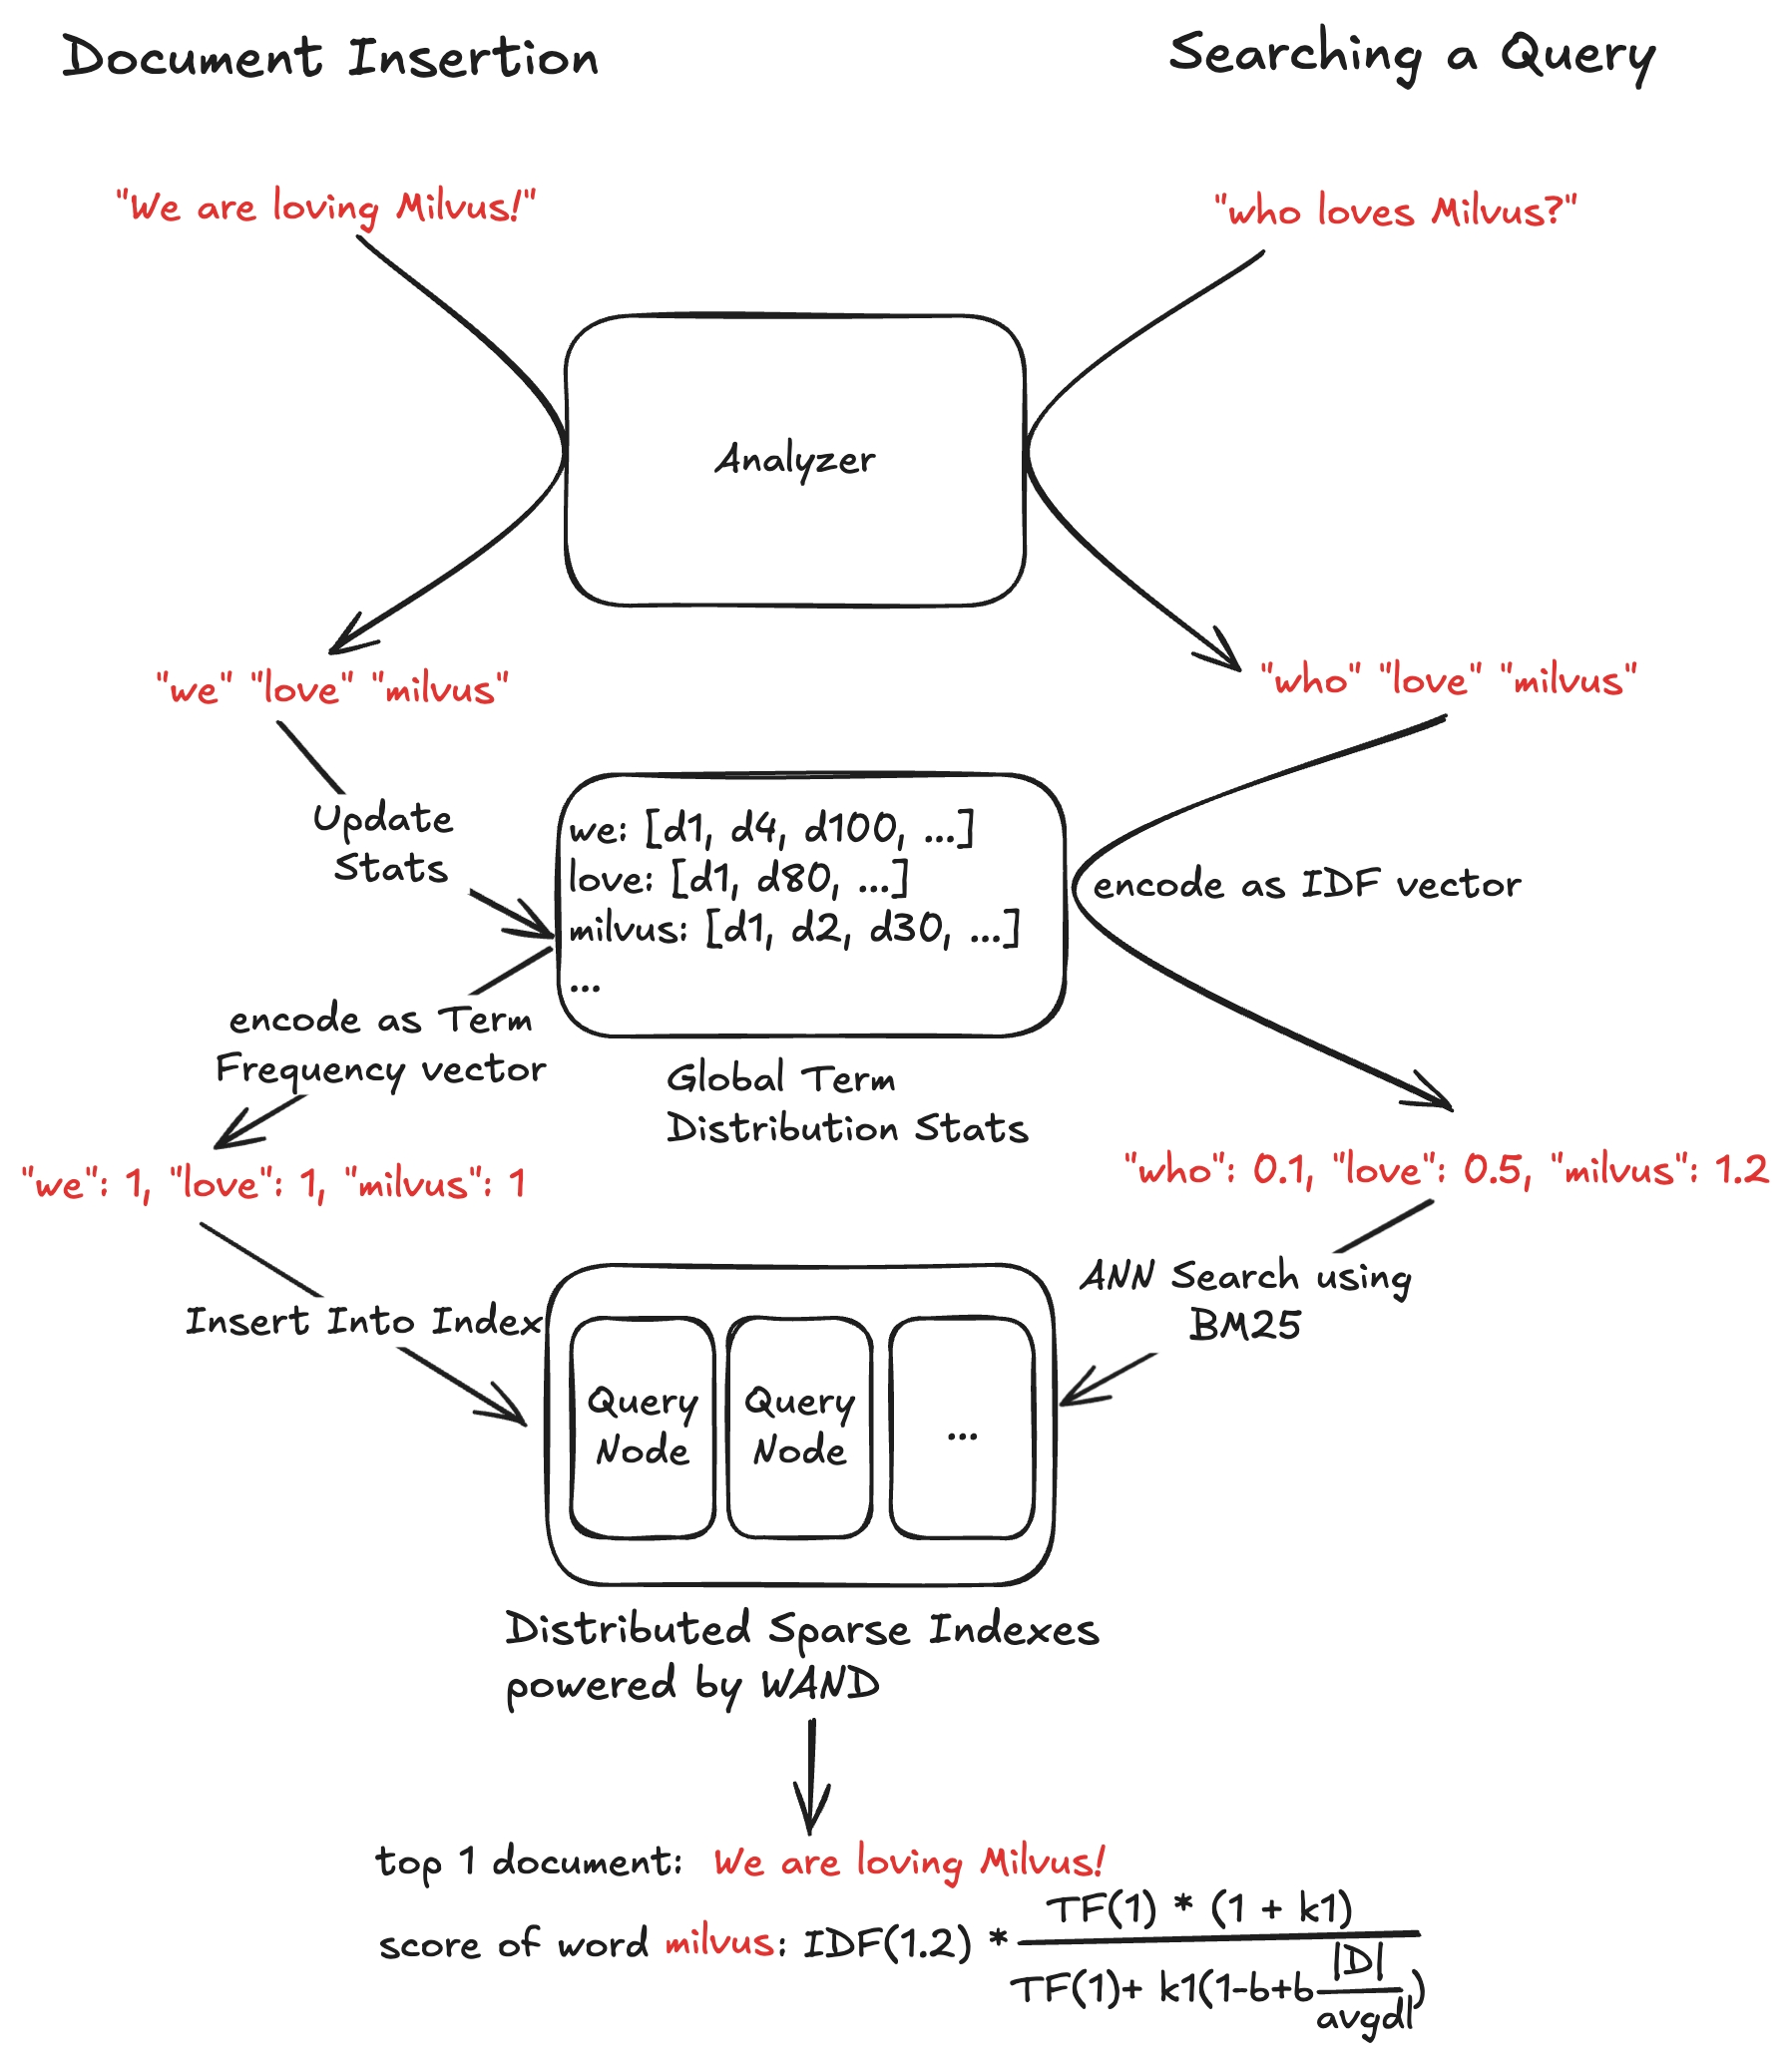
 
-------

Milvus 支持稠密、稀疏和 **混合检索(Hybrid Search)** 方式：

- **稠密检索**：利用语义上下文来理解查询背后的含义。
- **稀疏检索**：强调关键字匹配，根据具体词语来寻找结果，相当于全文搜索。
- **混合检索**：结合稠密和稀疏方式，既能捕捉完整的语义上下文，也能匹配特定关键词，从而实现更全面的搜索结果

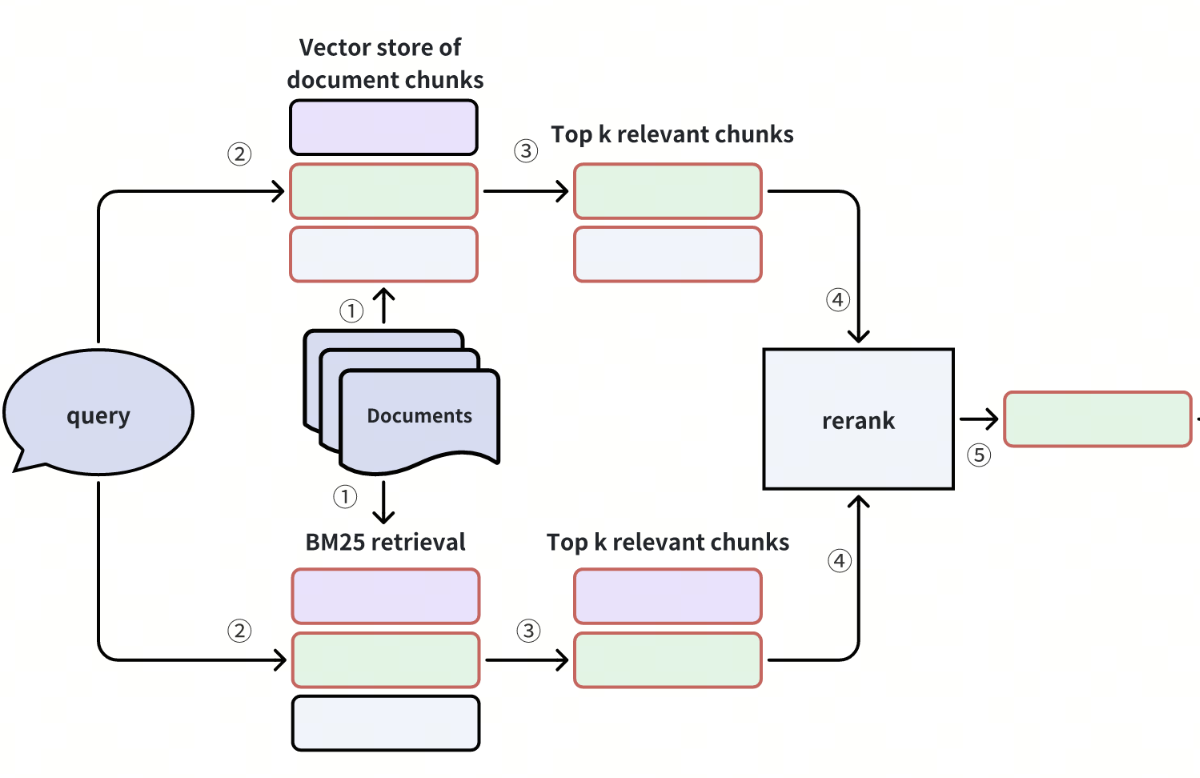

 ### 实操：执行混合查询



**查询集合**

为了支持 BM25 稀疏过滤，需要在集合中添加 **book_sparse** 字段，并确保 book_title 启用分析器（**enable_analyzer=True**），以便 Milvus 可以对文本进行分词和处理。



In [23]:
from pymilvus import CollectionSchema, FieldSchema, DataType, Function, FunctionType

field_book_id = FieldSchema(name="book_id", dtype=DataType.INT64, is_primary=True, auto_id=True)

analyzer_params = {"tokenizer": "standard"}
field_book_title = FieldSchema(name="book_title", 
                               dtype=DataType.VARCHAR, 
                               max_length=512,
                               analyzer_params=analyzer_params,
                               enable_analyzer=True)
field_publication_year = FieldSchema(name="publication_year", dtype=DataType.INT32)
field_book_embedding = FieldSchema(name="book_embedding", dtype=DataType.FLOAT_VECTOR, dim=768)
field_book_sparse = FieldSchema(name="book_sparse", dtype=DataType.SPARSE_FLOAT_VECTOR)

book_schema_def = CollectionSchema(
    fields=[field_book_id, field_book_title, field_publication_year, field_book_embedding, field_book_sparse],
    description="Collection for storing book information and embeddings",
    enable_dynamic_field=False
)

# BM25 函数会自动将 book_title 的文本转换为稀疏向量，存储在 book_sparse 字段中
bm25_function = Function(
    name="book_title_bm25_emb",
    input_field_names=["book_title"],
    output_field_names=["book_sparse"],
    function_type=FunctionType.BM25
)
book_schema_def.add_function(bm25_function)

# 创建索引
index_params = MilvusClient.prepare_index_params()
index_params.add_index(
    field_name="book_embedding",
    metric_type="COSINE",
    index_type="IVF_FLAT",
    index_name="vector_index",
    params={ "nlist": 128 }
)
index_params.add_index(
    field_name="book_sparse",
    index_type="SPARSE_INVERTED_INDEX",
    metric_type="BM25",
)

if client.has_collection(EXERCISE_COLLECTION_NAME):
    client.drop_collection(EXERCISE_COLLECTION_NAME)
    
# 测试collection 名字
EXERCISE_COLLECTION_NAME = "book_search_hybrid"
client.create_collection(collection_name=EXERCISE_COLLECTION_NAME, 
                         schema=book_schema_def,
                         index_params=index_params)

print(f"Collection '{EXERCISE_COLLECTION_NAME}' created successfully")

Collection 'book_search_hybrid' created successfully


In [26]:
import random

books = [
    {"book_title": "Pride and Prejudice", "publication_year": 1813, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
    {"book_title": "1984", "publication_year": 1949, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
    {"book_title": "The Catcher in the Rye", "publication_year": 1951, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
    {"book_title": "Moby-Dick", "publication_year": 1851, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
    {"book_title": "Brave New World", "publication_year": 1932, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
    {"book_title": "The Hobbit", "publication_year": 1937, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
    {"book_title": "Lord of the Flies", "publication_year": 1954, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
    {"book_title": "Jane Eyre", "publication_year": 1847, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
    {"book_title": "Animal Farm", "publication_year": 1945, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
    {"book_title": "Fahrenheit 451", "publication_year": 1953, "book_embedding": [random.uniform(0, 1) for _ in range(768)]},
]
client.insert(collection_name=EXERCISE_COLLECTION_NAME, data=books)

{'insert_count': 10, 'ids': [457888763904009812, 457888763904009813, 457888763904009814, 457888763904009815, 457888763904009816, 457888763904009817, 457888763904009818, 457888763904009819, 457888763904009820, 457888763904009821], 'cost': 0}

In [38]:
print("\n开始执行混合查询...")

# 准备查询向量
# query_vectors = [np.random.rand(DIMENSION_SEARCH).astype(np.float32).tolist() for _ in range(num_query_vectors)]
query_text = "classic american literature"
query_vectors = [0.5] * 768
limit_num = 3

# %%
# 创建 AnnSearchRequest 对象
from pymilvus import AnnSearchRequest, RRFRanker

dense_req = AnnSearchRequest(
    data=[query_vectors],
    anns_field="book_embedding",
    param={"metric_type": "COSINE"},
    # expr=filter_strategy1,
    limit=limit_num
)

sparse_req = AnnSearchRequest(
    data=[query_text],
    anns_field="book_sparse",
    param={"metric_type": "BM25"},
    # expr=filter_strategy2,
    limit=limit_num
)

# 定义 RRFRanker (Reciprocal Rank Fusion)
# RRFRanker 会根据每个结果在各自召回列表中的排名来计算一个融合分数
# k 是 RRF 算法内部的一个平滑参数，通常取60左右，影响分数计算。
rrf_ranker = RRFRanker(k=60)

print(f"\n准备执行 hybrid_search，融合两路召回，最终返回 Top {limit_num}。")

# %%
# 执行 hybrid_search
try:
    hs_results = client.hybrid_search(
        collection_name=EXERCISE_COLLECTION_NAME,
        reqs=[dense_req, sparse_req], # 包含两个召回请求
        ranker=rrf_ranker,                           # 使用 RRFRanker 进行融合
        limit=limit_num,                             # 最终返回的结果数量
        output_fields=["book_title", "publication_year"],
        consistency_level="Strong"
    )
    print("多策略 hybrid_search 完成。")

    # 解释结果 
    if not hs_results or not hs_results[0]:
        print("多策略 hybrid_search 没有返回任何结果。")
    else:
        results_for_query = hs_results[0] # 对应第一个 (也是唯一的) 查询向量的结果
        print(f"\n查询向量 #1 的多策略 hybrid_search 结果 (最终 Top {limit_num}):")
        for i, hit in enumerate(results_for_query): # hit 是一个 Hit 对象
            entity_id = hit.id
            fusion_score = hit.score # 这是 RRFRanker 计算出的融合分数
            fields = hit.entity

            print(f"  - 结果 #{i+1}: ID: {entity_id}, RRF融合分数: {fusion_score:.4f}, 书名: {hit.entity.book_title}")

except Exception as e:
    print(f"多策略 hybrid_search 失败: {e}")
    raise


开始执行混合查询...

准备执行 hybrid_search，融合两路召回，最终返回 Top 3。
多策略 hybrid_search 完成。

查询向量 #1 的多策略 hybrid_search 结果 (最终 Top 3):
  - 结果 #1: ID: 457888763904009813, RRF融合分数: 0.0164, 书名: 1984
  - 结果 #2: ID: 457888763904009815, RRF融合分数: 0.0161, 书名: Moby-Dick
  - 结果 #3: ID: 457888763904009817, RRF融合分数: 0.0159, 书名: The Hobbit


 ### Hands-on Exercise 4: 搜索与查询实践

 **任务**:
 1.  **向量搜索**:
     *   为 `book_search` Collection 准备一个新的随机查询向量。
     *   执行一次向量搜索，查找 Top 3 最相似的书籍。
     *   使用之前创建的 HNSW 索引的搜索参数 (例如 `ef=32`)。
     *   输出结果的 `id`, `distance`, `book_title`。
 2.  **数据查询**:
     *   执行一次数据查询，查找 `publication_year` 在 `[2000, 2005]` (包含两端) 之间的所有书籍。
     *   输出结果的 `book_id`, `book_title`, `publication_year`。
     *   限制返回最多 10 条。
 3.  **混合查询**:
     *   使用步骤1中相同的查询向量。
     *   执行一次混合查询，查找 Top 3 最相似的书籍，但附加条件：`publication_year < 1995`。
     *   输出结果的 `id`, `distance`, `book_title`, `publication_year`。